In [102]:
##Datos vivienda

#rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, showtext, srvyr, gt)
font_add_google("Poppins", "pop")
showtext_auto()

In [103]:
##Crear folders de almacenamiento
dir.create("vivienda/microdatos", showWarnings = F)

In [104]:
# Función para descargar y descomprimir un archivo con timeout
download_and_unzip <- function(url, destination="vivienda/microdatos") {
  tryCatch({
    # Descargar el archivo con timeout
    download.file(url, destfile = paste0(destination, "/", basename(url)), mode = "wb", timeout = 10000)

    # Descomprimir el archivo
    unzip(paste0(destination, "/", basename(url)), exdir = destination)

    # Eliminar el archivo comprimido después de descomprimirlo
    unlink(paste0(destination, "/", basename(url)))

    message(paste("Descarga y descompresión exitosas para", basename(url)))
  }, error = function(e) {
    warning(paste("Error al descargar o descomprimir", basename(url), ":", conditionMessage(e)))
  })
}

In [105]:
download_and_unzip("https://www.inegi.org.mx/contenidos/programas/enigh/nc/2024/microdatos/enigh2024_ns_concentradohogar_csv.zip")
download_and_unzip("https://www.inegi.org.mx/contenidos/programas/enigh/nc/2024/microdatos/enigh2024_ns_viviendas_csv.zip")

Warning message in download.file(url, destfile = paste0(destination, "/", basename(url)), :
"downloaded length 5029360 != reported length 13171058"
Warning message in download.file(url, destfile = paste0(destination, "/", basename(url)), :
"URL 'https://www.inegi.org.mx/contenidos/programas/enigh/nc/2024/microdatos/enigh2024_ns_concentradohogar_csv.zip': Timeout of 60 seconds was reached"
Warning message in value[[3L]](cond):
"Error al descargar o descomprimir enigh2024_ns_concentradohogar_csv.zip : download from 'https://www.inegi.org.mx/contenidos/programas/enigh/nc/2024/microdatos/enigh2024_ns_concentradohogar_csv.zip' failed"
Warning message in download.file(url, destfile = paste0(destination, "/", basename(url)), :
"URL 'https://www.inegi.org.mx/contenidos/programas/enigh/nc/2024/microdatos/enigh2024_ns_viviendas_csv.zip': Timeout of 60 seconds was reached"
Warning message in value[[3L]](cond):
"Error al descargar o descomprimir enigh2024_ns_viviendas_csv.zip : no fue posible abri

In [111]:
viviendas <- read_csv("vivienda/microdatos/viviendas.csv",show_col_types=FALSE)%>%

mutate(cve_ent = case_when(
      nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
      nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    )) 
    
    
vivi_tenencia<-viviendas%>%
    # Filtrar si entidad es 9
  filter(cve_ent == "09")%>%
  mutate(tenencia2=case_when(
    tenencia==1 ~ "Renta",
    tenencia %in% c(3,4) ~ "Propia",
    TRUE ~ "Otro tipo"))%>%
  select(folioviv,tenencia,tenencia2,pago_viv)

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


In [127]:
tothogares<-read_csv("vivienda/microdatos/concentradohogar.csv",show_col_types=FALSE)%>%
  mutate(cve_ent = case_when(
      nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
      nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    )) 
 
 
 hog_pagando<-tothogares%>%
    # Filtrar si entidad es 9
  filter(cve_ent == "09")%>%
  #Crear deciles
  mutate(quintil = ntile(ing_cor, 5))%>%
  #Pegar con viviendas
  left_join(vivi_tenencia, by = "folioviv")


hogtenencia<-tothogares%>%
    # Filtrar si entidad es 9
  filter(cve_ent == "09")%>%
  #Crear grupos de edad
      mutate(grupo_edad_jefe = case_when(
      edad_jefe < 30              ~ "15-29",
      edad_jefe >= 30 & edad_jefe <= 44 ~ "30-44",
      edad_jefe >= 45 & edad_jefe <= 59 ~ "45-59",
      edad_jefe >= 60 & edad_jefe <= 64 ~ "60-64",
      edad_jefe >= 65              ~ "65+",
      TRUE                         ~ NA_character_
    ))%>%
    left_join(vivi_tenencia,by="folioviv")
  

In [128]:
options(survey.lonely.psu = "adjust")  # evita CV inflados por PSU solitaria
dm1<-hog_pagando%>%
as_survey_design(ids = upm, 
weights = factor,strata=est_dis,
 nest = TRUE)

 dm2<-hogtenencia%>%
as_survey_design(ids = upm, 
weights = factor,strata=est_dis,
 nest = TRUE)

In [129]:
##Calcular cuánto representa el pago de la vivienda como porcentaje del ingreso corriente mensual del hogar, por decil de ingreso
pago_vivienda<-dm1%>%
  filter(tenencia %in% c(3))%>%
  #Calcular ingreso corriente mensual
    mutate(ing_mensual=ing_cor/3)%>%
     group_by(quintil) %>%
  summarise(
    ing_mensual_prom = survey_mean(ing_mensual, na.rm = TRUE, vartype = "cv"),
    pct_pago_viv = survey_ratio(pago_viv, ing_mensual, na.rm = TRUE, vartype = "cv")
  ) %>%
  mutate(
    pct_pago_viv = pct_pago_viv * 100
  )
pago_vivienda

quintil,ing_mensual_prom,ing_mensual_prom_cv,pct_pago_viv,pct_pago_viv_cv
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,10016.33,0.16636913,21.19141,0.1590014
2,17715.43,0.03702454,15.33597,0.2096834
3,26386.91,0.01782906,14.14130,0.1556369
4,38849.24,0.03481490,12.99968,0.1726961
5,96697.09,0.10571964,15.65199,0.1410050


In [130]:
##Crear tabla de gt
pago_vivienda%>%
  select(-c(ing_mensual_prom_cv,pct_pago_viv_cv))%>%
  gt()%>%
  fmt_percent(
    columns = vars(pct_pago_viv),
    decimals = 1
  )%>%
  fmt_number(
    columns = vars(ing_mensual_prom),
    decimals = 0,
    use_seps = TRUE
  )%>%
  fmt_number(columns = vars(pct_pago_viv), decimals = 1) %>%
  cols_label(
    quintil = "Quintil de ingreso",
    ing_mensual_prom = "Ingreso corriente mensual promedio (pesos)",
    pct_pago_viv = "Porcentaje del ingreso corriente mensual destinado al pago de la vivienda"
  )%>%
  tab_header(
    title = md("**Porcentaje del ingreso corriente mensual destinado al pago de la vivienda de los hogares por quintil de ingreso en la Ciudad de México, 2024**"),
  )%>%
   tab_source_note(
    source_note = "Nota: Se consideran únicamente aquellos hogares que habitan en viviendas propias en proceso de pago."
  )%>%
  tab_source_note(
    source_note = "Fuente: Elaboración propia con base en INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) 2024."
  )%>%
    opt_table_font(font = list(google_font("Poppins"), default_fonts())) %>%
tab_options(
    heading.align = "center",
    table.align   = "center",
    table.font.size = px(14),
    table.background.color = "white",
    table.border.top.color = "white",
    table.border.bottom.color = "white",
    data_row.padding = px(3),
    column_labels.font.weight = "bold",
    column_labels.border.top.color = "black",
    column_labels.border.bottom.color = "black",
    column_labels.border.bottom.width = px(2),
    table_body.hlines.color = "lightgrey",
    table_body.hlines.width = px(0.5),
    table_body.border.bottom.color = "black",
    table_body.border.bottom.width = px(2),
    source_notes.font.size = px(10),
    source_notes.padding = px(1)
  ) %>%
  # centrar celdas, labels y spanners
  cols_align(align = "center", columns = everything()) %>%
  tab_style(
    style = cell_text(align = "center"),
    locations = list(
      cells_column_labels(columns = everything()),
      cells_column_spanners(spanners = everything())
    )
  )%>%
  gtsave("vivienda/pago_vivienda.png", expand=10)

Warning message:
"Since gt v0.3.0, `columns = vars(...)` has been deprecated.
• Please use `columns = c(...)` instead."
Warning message:
"Since gt v0.3.0, `columns = vars(...)` has been deprecated.
• Please use `columns = c(...)` instead."
Warning message:
"Since gt v0.3.0, `columns = vars(...)` has been deprecated.
• Please use `columns = c(...)` instead."
Warning message:
"Since gt v0.3.0, `columns = vars(...)` has been deprecated.
• Please use `columns = c(...)` instead."
Warning message:
"Since gt v0.3.0, `columns = vars(...)` has been deprecated.
• Please use `columns = c(...)` instead."
Warning message:
"Since gt v0.3.0, `columns = vars(...)` has been deprecated.
• Please use `columns = c(...)` instead."


In [132]:
gpo_edad_tenencia<-dm2%>%
group_by(grupo_edad_jefe,tenencia2)%>%
summarise(pct_hog=survey_prop(vartype="cv"))%>%
mutate(pct_hog=pct_hog*100)
gpo_edad_tenencia

grupo_edad_jefe,tenencia2,pct_hog,pct_hog_cv
<chr>,<chr>,<dbl>,<dbl>
15-29,Otro tipo,23.007186,0.20212605
15-29,Propia,21.515700,0.20864051
15-29,Renta,55.477114,0.10490034
30-44,Otro tipo,18.922266,0.10236958
30-44,Propia,38.098223,0.06290618
30-44,Renta,42.979511,0.05434424
45-59,Otro tipo,22.507813,0.07607725
45-59,Propia,57.494300,0.03689650
45-59,Renta,19.997887,0.08434929


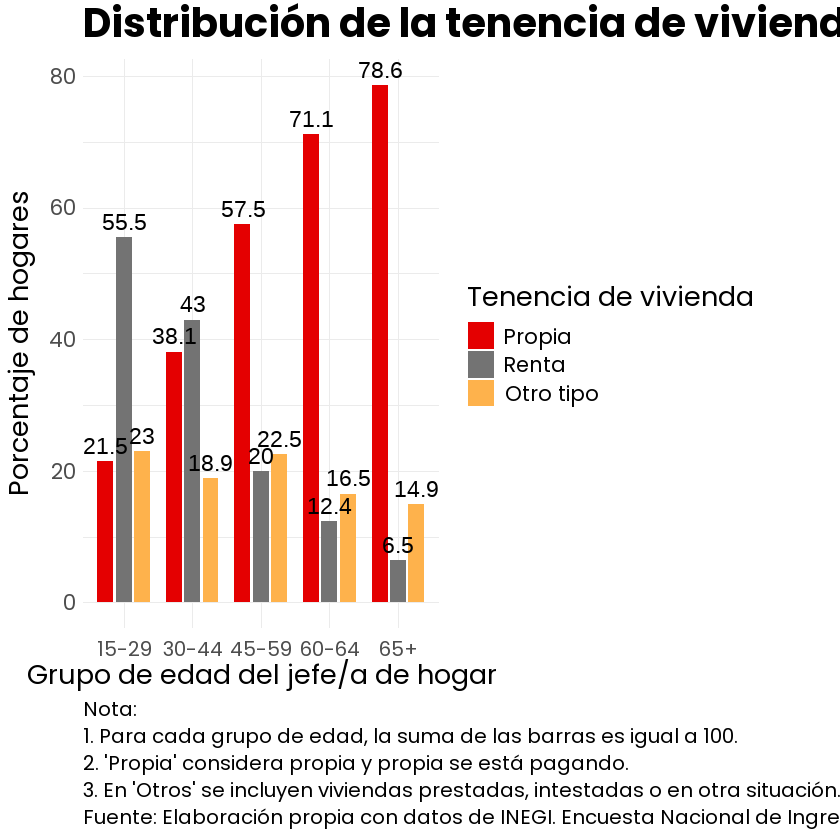

In [ ]:
gpo_edad_tenencia%>%ggplot( aes(
x = factor(
    grupo_edad_jefe,
    levels = c("15-29", "30-44", "45-59", "60-64", "65+")
  ),
  y = pct_hog,
  fill = factor(
    tenencia2,
    levels = c("Propia", "Renta", "Otro tipo")
  )
))  +
  geom_col(position = position_dodge(width = 0.8), width = 0.7) +
  geom_text(
    aes(label = round(pct_hog, 1)),
    position = position_dodge(width = 0.8),
    vjust = -0.5, size = 6, colour = "black"
  ) +
  scale_fill_manual(values = c("#e40001", "#737373", "#feb24c")) +
  labs(
    x = "Grupo de edad del jefe/a de hogar",
    y = "Porcentaje de hogares",
    fill = "Tenencia de vivienda",
    title = "Distribución de la tenencia de vivienda por grupo de edad de la persona jefa del hogar, 2024",
        caption = "Nota: 
1. Para cada grupo de edad, la suma de las barras es igual a 100.
2. 'Propia' considera propia y propia se está pagando.
3. En 'Otros' se incluyen viviendas prestadas, intestadas o en otra situación.
Fuente: Elaboración propia con datos de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares, 2024.")+    
    theme(
plot.title = element_text(hjust = 0, size=30,face="bold"),
  ) +
  theme_minimal(base_family = "Poppins") +
    theme(
            plot.title = element_text(hjust = 0, size=30,face="bold"),
            plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
            plot.caption = element_text(hjust = 0,size=15),
            axis.text.x = element_text(angle = 0, vjust = 0.5,size=15),
            text=element_text("pop",size=20))

#Salvar gráfica
ggsave("vivienda/dist_tenencia_edad_jefe.png",width=20,height=10, dpi=100,bg="white")